In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

C:\DAHOU\AuxiliaryProgram\VirtualEnvironment\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


Calculate hourly return:

In [2]:
def return_oc(df):
    return np.log(df.open/df.close)

Calculate hourly volatility:

In [3]:
def vol_ohlc(df, lookback=10):
    o, h, l, c = df.open, df.high, df.low, df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc, ho, lo, co, oc = np.log(c/c.shift(1)), np.log(h/o), np.log(l/o), np.log(c/o), np.log(o/c.shift(1))
    oc_sq, cc_sq = oc**2, cc**2
    rs = ho * (ho - co) + lo * (lo - co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

Calculate hourly max drawdown:

In [4]:
def max_drawdown_hl(df):
    rolling_max = df.high.cummax()
    hourly_drawdown = df.low / rolling_max - 1
    hourly_mdd = hourly_drawdown.cummin()
    return hourly_mdd

Plotting in a 2 by 2 box:

In [5]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

In [6]:
token = 'BTC'
from_date = '2021-12-02'
to_date = '2021-12-15'
connection_string = 'sqlite:///data.db'

In [7]:
# Parameters
from_date = "2021-12-02"
to_date = "2021-12-15"
token = "COMP"
connection_string = "sqlite:///data.db"


In [8]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])
prices.set_index('ts', inplace=True)

In [9]:
prices['return'] = return_oc(prices)
prices['vol'] = vol_ohlc(prices)
prices['maxDrawdown'] = max_drawdown_hl(prices)

In [10]:
%%capture
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

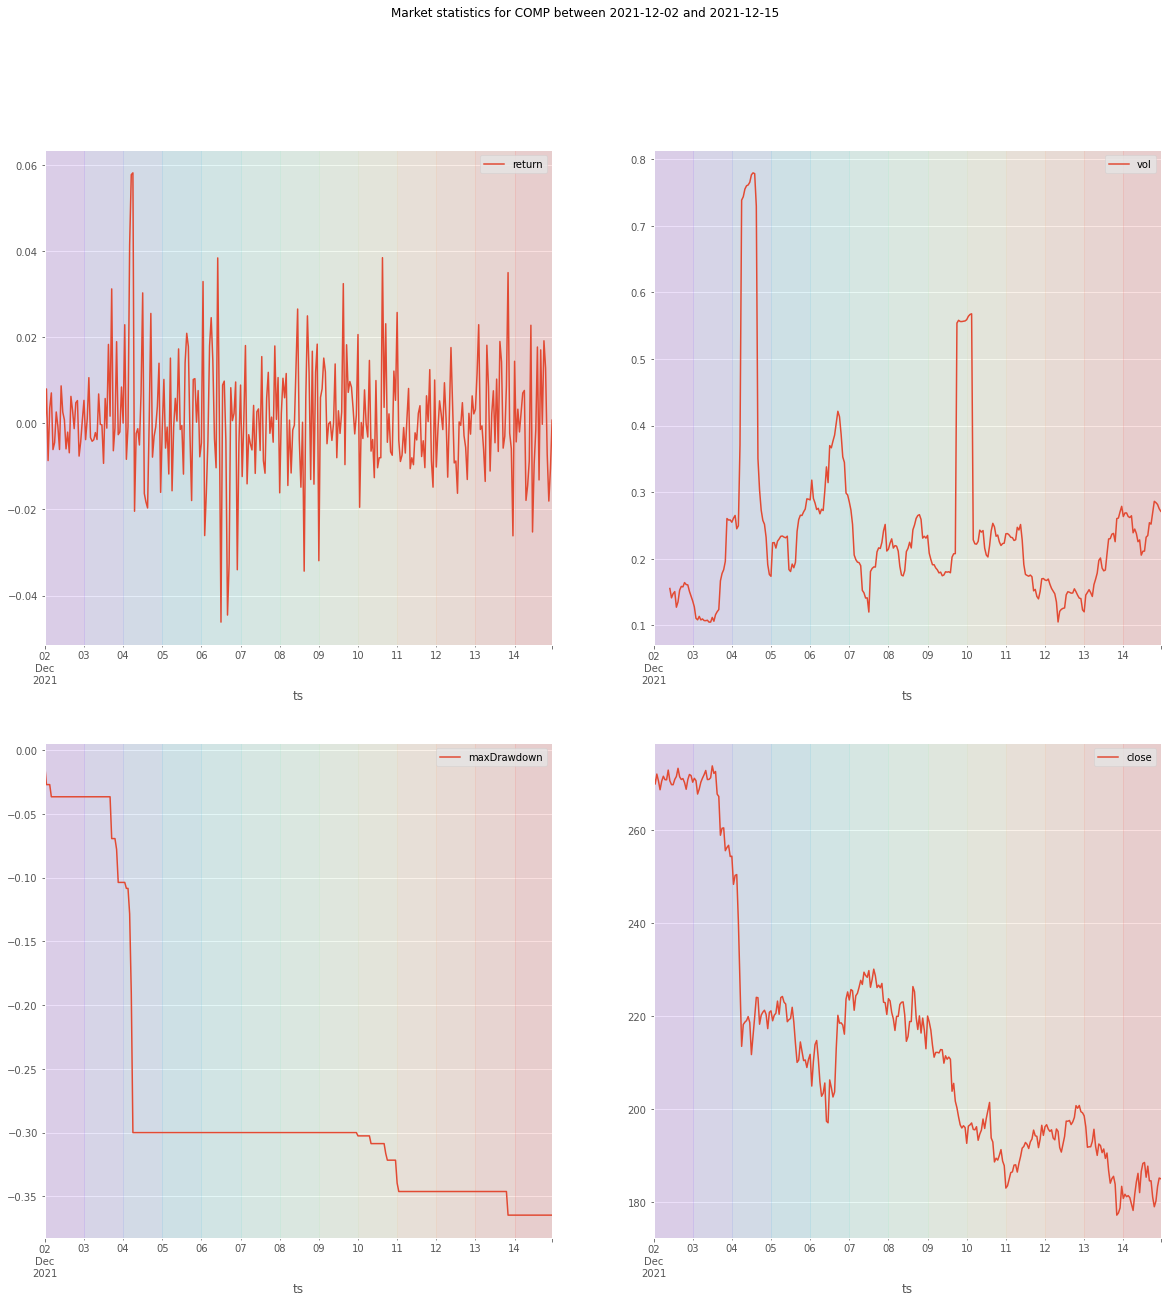

In [11]:
series_plot(prices[['return']], ax = ax[0, 0])
series_plot(prices[['vol']], ax = ax[0, 1])
series_plot(prices[['maxDrawdown']], ax = ax[1, 0])
series_plot(prices[['close']], ax = ax[1, 1])
fig.suptitle(f'Market statistics for {token} between {from_date} and {to_date}')
fig

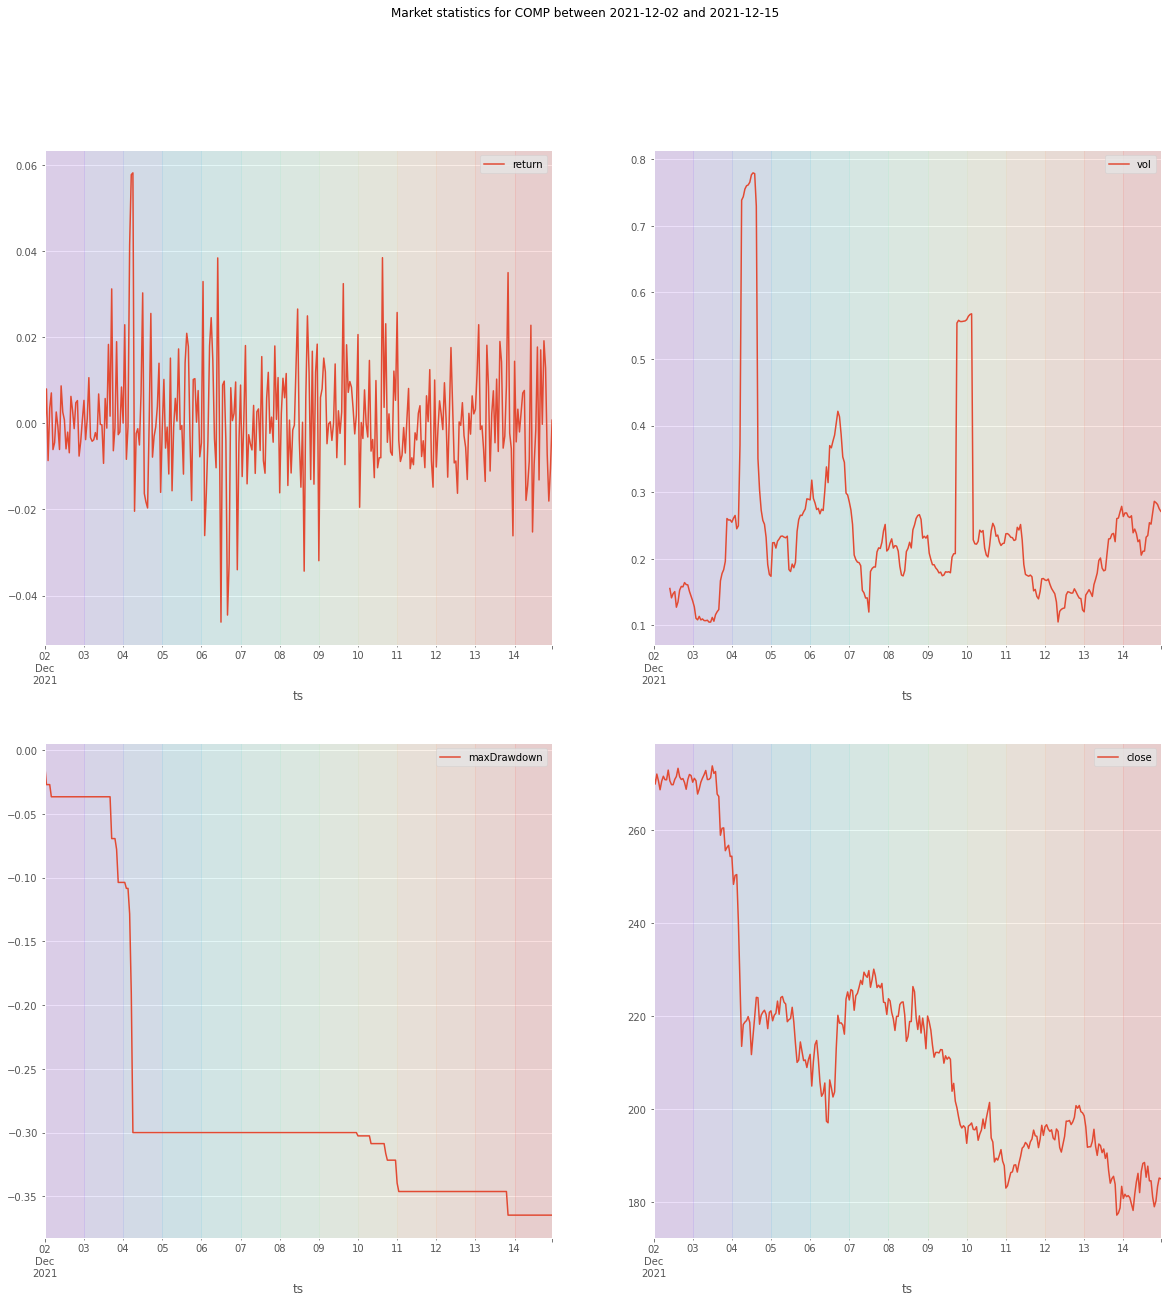

In [12]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)